# XPCS&XSVS Pipeline for SAXSGi-Single-SAXS Run
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [70]:
from chxanalys.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
#%reset -f  #for clean up things in the memory

## Control Runs Here

In [194]:
scat_geometry = 'gi_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)

force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = True #False   #run waterfall analysis
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_one_time = True  #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = True #False #True #True #False    #run  two-time
run_four_time = True #False   #run  four-time
run_xsvs= True #False         #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog
qth_interest = 3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name
if scat_geometry == 'gi_saxs':run_xsvs= False 
    

In [195]:
taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

## Make a directory for saving results

In [196]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir0 = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir0, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir0)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/


## Load Metadata & Image Data



### Change this line to give a uid

In [200]:
uid = '96c5dd'  #count : 1 ['8a5346'] (scan num: 9948) (Measurement: XPCS series alpha=0.16,.1s &4.9s 100 frames )

#uid = '89297ae8'


In [201]:
#start_time, stop_time = '2016-11-30  17:41:00', '2016-11-30  17:46:00'  
#sids, uids = find_uids(start_time, stop_time)

In [202]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/


# Don't Change these lines below here

* get metadata

In [203]:
md = get_meta_data( uid )

* get data

In [204]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

hdf5 path = /XF11ID/data/2016/11/19/a5de0dc7-2c64-400c-9775_694_master.h5
The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 100 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint32


In [205]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distanc', 'beam_center_x', 'beam_center_y', ] )

suid--> 96c5dd
number of images--> 100
uid--> 96c5dddd-fe04-4385-9ef6-93669e408486
scan_id--> 9956
start_time--> 2016-11-19 20:25:58
stop_time--> 2016-11-19 20:34:14
sample--> psp4vp6024hann
Measurement--> XPCS series alpha=0.16,.1s &4.9s 100 frames
acquire period--> 10.0
exposure time--> 9.999990463256836
det_distanc--> 4.89
beam_center_x--> 1477.0
beam_center_y--> 346.0


## Overwrite Some Metadata if Wrong Input

In [206]:
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = md['detector_distance'] *1000     # detector to sample distance (mm)

try:
    exposuretime= md['cam_acquire_t']     #exposure time in sec
except:    
    exposuretime= md['count_time']     #exposure time in sec
try:
    acquisition_period = float( db[uid]['start']['acquire period'] )
except:    
    acquisition_period = md['frame_time'] 
timeperframe = acquisition_period #for g2

inc_x0 = None
inc_y0=  None

if inc_x0 is not None:
    md['beam_center_x']= inc_x0
if inc_y0 is not None:
    md['beam_center_y']= inc_y0         
center = [  int(md['beam_center_y']),int( md['beam_center_x'] ) ]  #beam center [y,x] for python image

#center = [ 2070-1381-0, 1475-4] 
setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

print_dict( setup_pargs )

uid--> uid=96c5dd
timeperframe--> 10.0
Ldet--> 4889.99986649
lambda_--> 1.28521
center--> [346, 1477]
exposuretime--> 0.1
path--> /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/
dpix--> 0.0750000035623


## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change the blow line to give mask filename

In [207]:
if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2016_3/masks/'
    mask_name =  'Nov16_4M-GiSAXS_mask.npy'
elif scat_geometry == 'saxs':
    mask_path = '/XF11ID/analysis/2016_3/masks/'
    mask_name = 'Nov28_4M_SAXS_mask.npy'

<IPython.core.display.Javascript object>


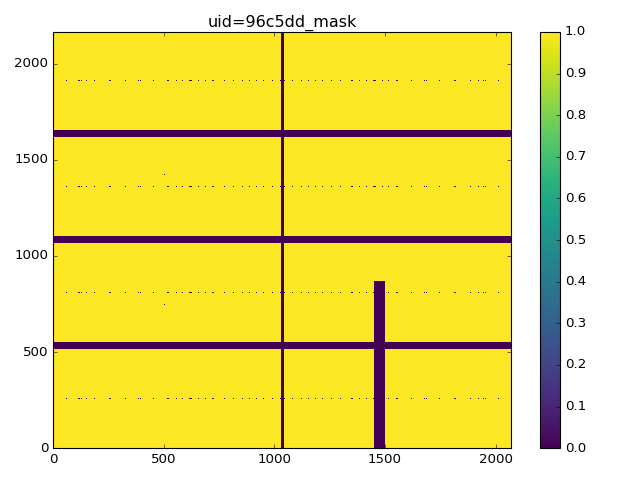

In [208]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse=True ) 
mask *= pixel_mask
mask[:,2069] =0 # False  #Concluded from the previous results
show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir)
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

# Check several frames average  intensity

In [209]:
img_choice_N = 3
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uidstr)
if avg_img.max() == 0:
    print('There are no photons recorded for this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')

<IPython.core.display.Javascript object>


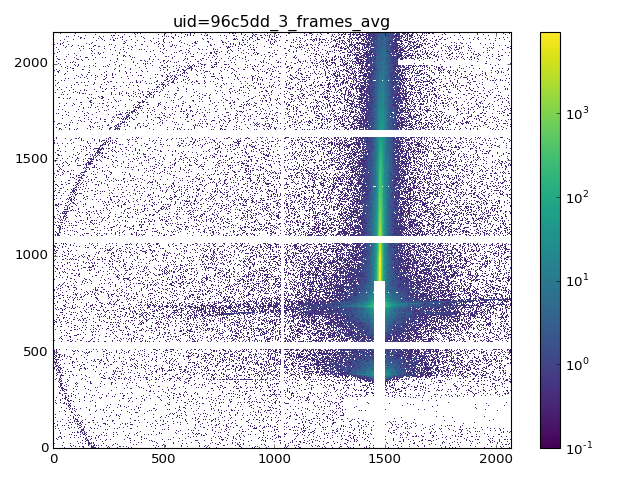

In [210]:
if scat_geometry !='saxs':
    show_img( avg_img,  vmin=.1, vmax=np.max(avg_img*.1), logs=True,
 image_name= uidstr + '_%s_frames_avg'%img_choice_N,  save=True, path=data_dir) 
else:    
    show_saxs_qmap( avg_img, setup_pargs, width=600, show_pixel = True,
       vmin=.1, vmax= np.max(avg_img), logs=True, image_name= uidstr + '_%s_frames_avg'%img_choice_N )

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [211]:
compress=True
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
#compress =  photon_occ < .4  #if the photon ocupation < 0.5, do compress
print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + 'Always ' + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.2543742434274326.
Will Always DO apply compress process.


In [212]:
good_start = 5  #make the good_start at least 0

Get each frame intensity:   3%|▎         | 3/100 [00:00<00:03, 24.47it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_96c5dddd-fe04-4385-9ef6-93669e408486.cmp.


Averaging 98 images:   6%|▌         | 6/100 [00:00<00:01, 56.48it/s]

No bad frames are involved.


Averaging 98 images: 100%|██████████| 100/100 [00:01<00:00, 55.17it/s]


The good_start frame number is: 5 
uid=96c5dd_fra_5_100


<IPython.core.display.Javascript object>


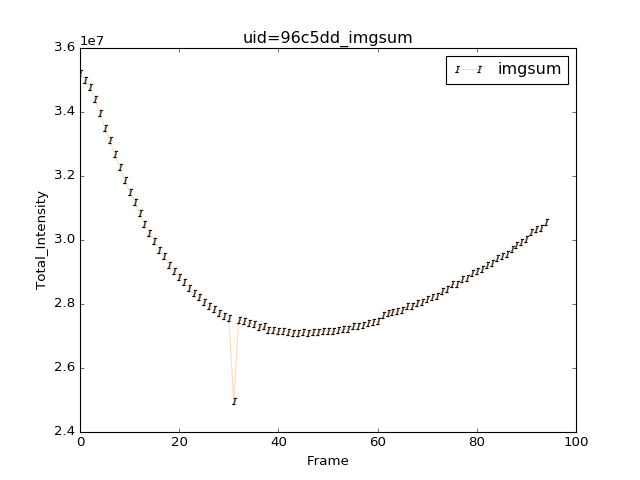

Total time: 0.06 min


In [213]:
t0= time.time()
filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%md['uid']
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= force_compress,  para_compress= para_compress,  bad_pixel_threshold= 1e14,
                        bins=1, num_sub= 100, num_max_para_process= 500  )
min_inten = 10    
good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
print ('The good_start frame number is: %s '%good_start)
FD = Multifile(filename, good_start, len(imgs))
#FD = Multifile(filename, good_start, 100)
uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
print( uid_ )
plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
       title =uidstr + '_imgsum', xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )

run_time(t0)

In [214]:
#%system   free && sync && echo 3 > /proc/sys/vm/drop_caches && free

## Get bad frame list by a polynominal fit

/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


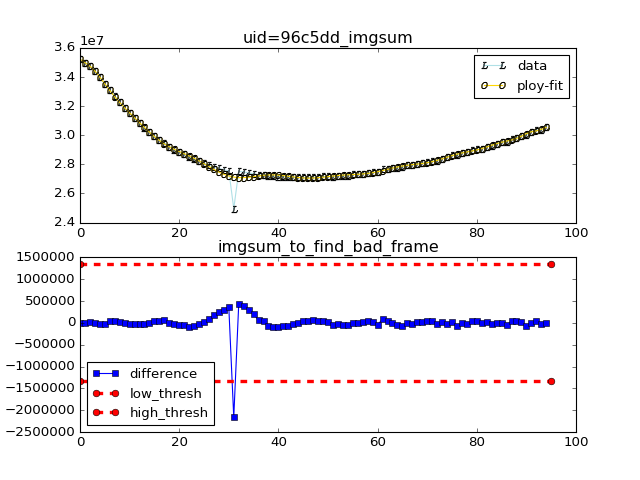

here
The bad frame list length is: 6


In [215]:
bad_frame_list =  get_bad_frame_list( imgsum, fit=True, plot=True,polyfit_order = 30, 
                        scale= 5.5,  good_start = good_start, uid= uidstr, path=data_dir)

print( 'The bad frame list length is: %s'%len(bad_frame_list) )

#### For beamline to find the bad pixels

In [299]:
#bp = find_bad_pixels( FD, bad_frame_list, md['uid'] )
#bp.to_csv('/XF11ID/analysis/Commissioning/eiger4M_badpixel.csv', mode='a'  )

### Creat new mask by masking the bad pixels and get new avg_img

In [217]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'],
           filename=uidstr + '_img_sum_t', path= data_dir  )


### Plot time~ total intensity of each frame

<IPython.core.display.Javascript object>


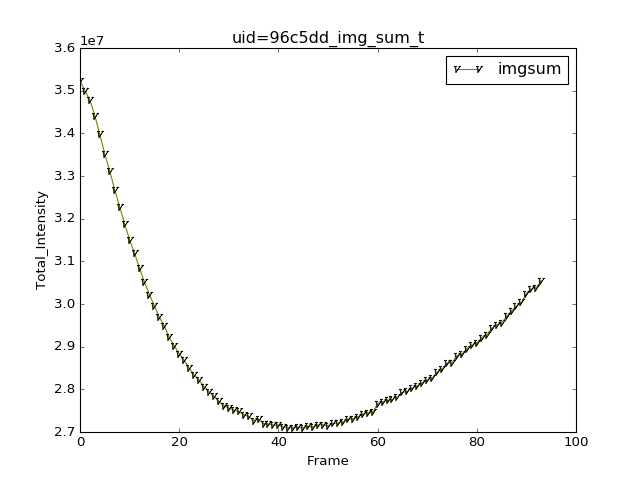

In [218]:
plot1D( y = imgsum_y, title = uidstr + '_img_sum_t', xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

### Plot intensity average image

<IPython.core.display.Javascript object>


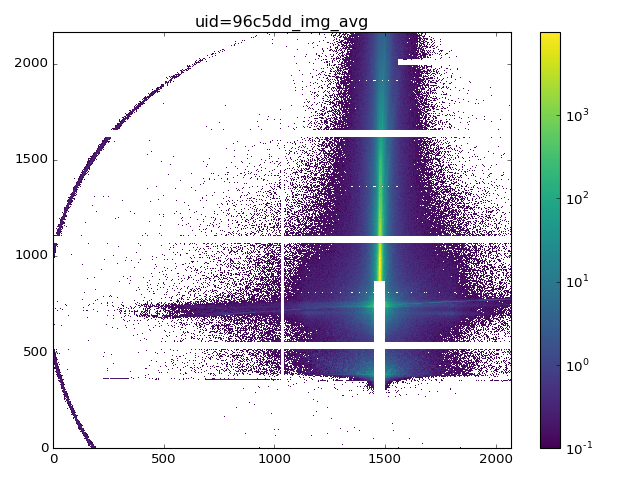

In [219]:
if scat_geometry =='saxs':
    show_saxs_qmap( avg_img, setup_pargs, width=600,vmin=.1, vmax=np.max(avg_img*1), logs=True,
       image_name= uidstr + '_img_avg',  save=True) 
elif scat_geometry =='gi_saxs':    
    show_img( avg_img,  vmin=.1, vmax=np.max(avg_img*.1), logs=True,
         image_name= uidstr + '_img_avg',  save=True, path=data_dir) 

# SAXS Scattering Geometry

In [221]:
if scat_geometry =='saxs':
    ## Get circular average| * Do plot and save q~iq
    hmask = create_hot_pixel_mask( avg_img, threshold = 100, center=center, center_radius= 400)
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, 
                      xlim=[q_saxs.min(), q_saxs.max()], ylim = [iq_saxs.min(), iq_saxs.max()] )
    
    pd = trans_data_to_pd( np.where( hmask !=1), 
            label=[md['uid']+'_hmask'+'x', md['uid']+'_hmask'+'y' ], dtype='list')
    pd.to_csv('/XF11ID/analysis/Commissioning/eiger4M_badpixel.csv', mode='a'  )
    mask =np.array( mask * hmask, dtype=bool) 
    #show_img( mask )

In [222]:
if scat_geometry =='saxs':
    if run_fit_form:        
        form_res = fit_form_factor( q_saxs,iq_saxs,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])  

In [223]:
if scat_geometry =='saxs':    
    uniformq = True #False    
    ## Define ROI
    #* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
    #* Create ring mask defined by  edges (all in pixel unit)    
    ### Define a non-uniform distributed rings by giving edges
    if not uniformq:    
        width = 0.0002    
        number_rings= 1    
        qcenters = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
        edges = get_non_uniform_edges(  qcenters, width, number_rings )    
        inner_radius= None
        outer_radius = None
        width = None
        num_rings = None        
    # Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)
    if uniformq:    
        inner_radius= 0.005 #0.006  #16
        outer_radius = 0.04 #0.05  #112    
        num_rings = 12
        gap_ring_number = 6
        width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
        edges = None

In [224]:
if scat_geometry =='saxs':
    roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
            outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                          unit='A',       pargs=setup_pargs   )
    qind, pixelist = roi.extract_label_indices(  roi_mask  ) 
    qr = np.round( qr, 4)
    show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth =700, alpha=.9,  
                     save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img), vmax= np.max(avg_img) ) 
    qval_dict = get_qval_dict( np.round(qr, 4)  ) 

In [225]:
if scat_geometry =='saxs':
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, xlim=[q_saxs.min(), q_saxs.max()],
                  ylim = [iq_saxs.min(), iq_saxs.max()],  save=True, path=data_dir)

# GiSAXS Scattering Geometry

The incident_angle (alphai) is: 0.157298186294
The incident_angle (alphai) is: 0.157298186294


<IPython.core.display.Javascript object>


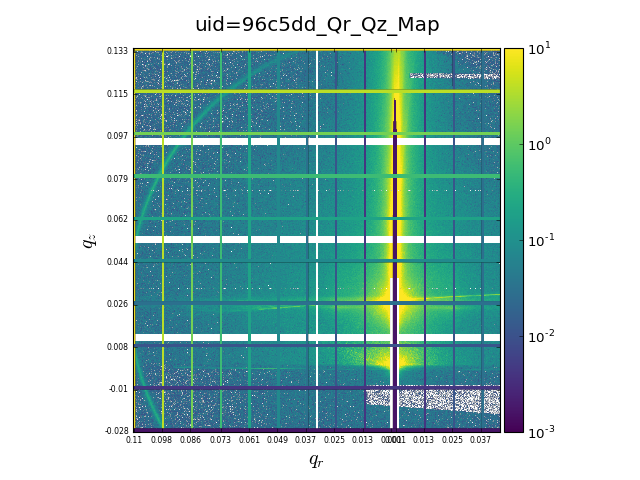

In [305]:
if scat_geometry =='gi_saxs':
    # Get Q-Map (Qz and Qr)
    ### Users put incident-Beam and Reflection_Beam Centers here!!!
    # Change these lines
    inc_x0 = 1473
    inc_y0 = 372
    refl_x0 = 1473
    refl_y0 = 730
    
    # Don't Change these lines below here
    alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
    qx_map, qy_map, qr_map, qz_map = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )
    ticks_  = get_qzr_map(  qr_map, qz_map, inc_x0, Nzline=10,  Nrline=10   )
    ticks = ticks_[:4]
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks_, data= avg_img, uid= uidstr, path = data_dir   )

In [340]:
if scat_geometry =='gi_saxs':
    # Define Q-ROI
    #* Users provide the interested Qz and Qr here for XPCS analysis, e.g., qr start/end/number/width et.al
    # Change these lines

    qz_start = 0.025
    qz_end = 0.04
    qz_num= 3
    gap_qz_num = 1
    
    qz_width = (qz_end - qz_start)/(qz_num +gap_qz_num)
    qr_start =  0.0025
    qr_end = 0.07
    qr_num = 14
    gap_qr_num = 5
    qr_width = ( qr_end- qr_start)/(qr_num+gap_qr_num)

    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]
    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )


<IPython.core.display.Javascript object>


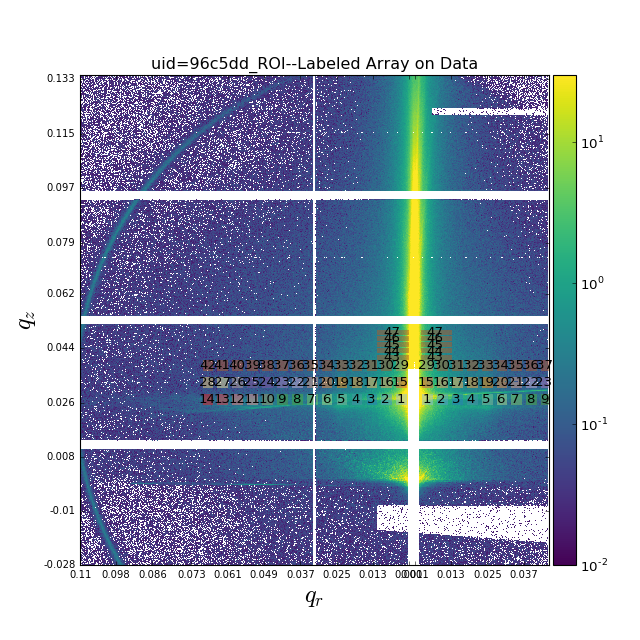

The qr_1d is saved in /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/ with filename as uid=96c5dd_qr_1d.csv


<IPython.core.display.Javascript object>


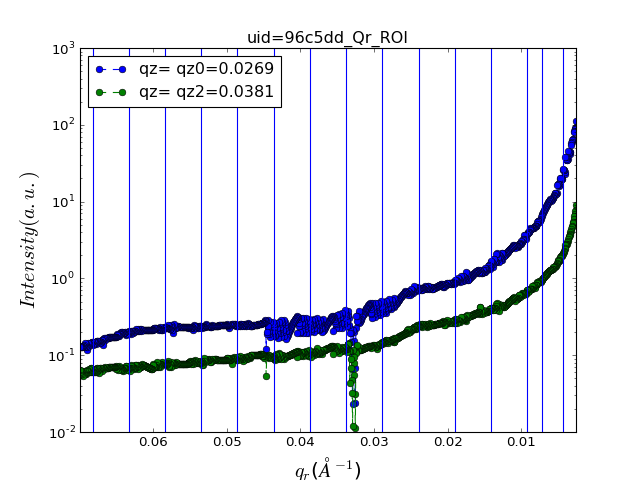

In [341]:
if scat_geometry =='gi_saxs':
    ### Change the below lines to if define another ROI, if define even more, just repeat this process
    define_second_roi = True #False  #if True to define another line; else: make it False
    if define_second_roi:    
        qval_dict1 = qval_dict.copy()
        roi_mask1 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Second ROI
    if define_second_roi:    
        qz_start2 = 0.04
        qz_end2 = 0.050
        qz_num2= 5
        gap_qz_num2 = 1
        qz_width2 = (qz_end2 - qz_start2)/(qz_num2 +gap_qz_num2)    
        qr_start2 =  0.002
        qr_end2 = 0.064
        qr_num2 = 1 #10
        gap_qr_num2 = 5
        qr_width2 = ( qr_end2- qr_start2)/(qr_num2+gap_qr_num2)
        Qr2 = [qr_start2 , qr_end2, qr_width2, qr_num2]
        Qz2=  [qz_start2,   qz_end2,  qz_width2 , qz_num2 ] 
        roi_mask2, qval_dict2 = get_gisaxs_roi( Qr2, Qz2, qr_map, qz_map, mask= mask )
        qval_dict = update_qval_dict(  qval_dict1, qval_dict2 )
        roi_mask = update_roi_mask(  roi_mask1, roi_mask2 )        
        show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )        
        ## Get 1D Curve (Q||-intensity¶)
        qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map,  setup_pargs=setup_pargs )
        plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=False, save=True, uid=uidstr, path = data_dir)

* Extract the labeled array

In [229]:
qind, pixelist = roi.extract_label_indices(roi_mask)
noqs = len(np.unique(qind))

* Number of pixels in each q box

In [230]:
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([4700, 4800, 4700, 4700, 4799, 4700, 4298, 4700, 4200, 2400, 2350,
       2349, 2400, 2350, 4641, 4764, 4636, 4660, 4732, 4664, 4216, 4660,
       4152, 2380, 2305, 2330, 2362, 2329, 4700, 4800, 4700, 4700, 4800,
       4700, 4297, 4700, 4200, 2400, 2350, 2350, 2400, 2350, 7370, 7370,
       7370, 7504, 7370, 7370, 7303, 3752, 3685, 3685])

## Check one ROI intensity

<IPython.core.display.Javascript object>


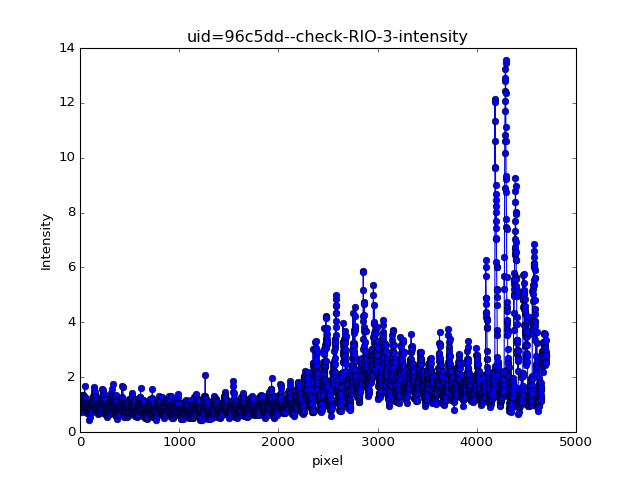

In [231]:
roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qth_interest, uid =uidstr )

## Check beam damage

In [232]:
if scat_geometry =='saxs':
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width= 1, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    print( time_edge )
    
    qpt, iqst, qt = get_t_iqc( FD, time_edge, mask, pargs=setup_pargs, nx=1500 )
    plot_t_iqc( qt, iqst, time_edge, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
           ylim = [iqst.min(), iqst.max()], save=True )

elif scat_geometry =='gi_saxs':
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width= 1, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    print( time_edge )
    
    qpt, iqst, qt = get_t_qrc( FD, time_edge, mask, pargs=setup_pargs, nx=1500 )
    plot_t_iqc( qt, iqst, time_edge, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
           ylim = [iqst.min(), iqst.max()], save=True )

      


In [348]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/XPCS_GiSAXS.py

qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map,  setup_pargs=setup_pargs )

The qr_1d is saved in /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/ with filename as uid=96c5dd_qr_1d.csv


In [342]:
qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, save=False )

In [368]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/XPCS_GiSAXS.py

In [404]:

def get_t_qrc( FD, frame_edge, Qr, Qz, qr, qz, mask=None, path=None, uid=None, *argv,**kwargs):   
    '''Get t-dependent qr 
    
        Parameters        
        ----------
        FD: a compressed imgs series handler
        frame_edge: list, the ROI frame regions, e.g., [  [0,100], [200,400] ]
        mask:  a image mask 
        
        nx : int, optional
            number of bins in x
            defaults is 1500 bins
        plot_: a boolen type, if True, plot the time~one-D curve with qp as x-axis
        Returns
        ---------
        qrt_pds: dataframe, with columns as 
            frame_edge index 0, 1, 2, and each value with shape as time length, frame_edge
     
    '''          
    
    Nt = len( frame_edge )
    iqs = list( np.zeros( Nt ) )
    qz_start,   qz_end,  qz_width , qz_num =Qz
    qz_edge, qz_center = get_qedge( qz_start,   qz_end,  qz_width , qz_num ) 
    #qr_1d = np.zeros(   )
    columns =[]
    if uid is None:
        uid = 'uid'
    for i in range(Nt):
        #str(round(qz_center[j], 4 )
        t1,t2 = frame_edge[i]       
        avg_imgx = get_avg_imgc( FD, beg=t1,end=t2, sampling = 1, plot_ = False ) 
        uid_ = uid + '_fra_%s_to_%s'%( t1, t2 )
        qrti = cal_1d_qr( avg_imgx, Qr, Qz, qr, qz, mask = mask, path=path, uid = uid_,print_save_message= False )  
        if i == 0:
            qrt_pds = np.zeros(  [len(qrti), 1 + Nt * qz_num ] )
            columns.append( 'qr' )
            qrt_pds[:,0] = qrti['qr']
        for j in range(qz_num):
            qrt_pds[:, 1 + j + qz_num*i] =  qrti[ qrti.columns[j] ]
            columns.append(   qrti.columns[j] )
    print( columns )
    qrt_pds = DataFrame( qrt_pds  )
    qrt_pds.columns = np.concatenate(  columns    )

    return qrt_pds

In [391]:
qrti = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, mask = mask,  save=False ) 

In [397]:
qrti.columns

Index(['qr', 'qz0=0.0269', 'qz1=0.0325', 'qz2=0.0381'], dtype='object')

In [396]:
qrti.columns[1]

'qz0=0.0269'

In [ ]:
qrt_pds = get_t_qrc( FD, time_edge, Qr, Qz, qr_map, qz_map, path=data_dir, uid = uidstr )

In [385]:
qrt_dict[2]

qr  qz0=0.0269  qz1=0.0325  qz2=0.0381
0     0.002549  115.000000   16.240000    8.240000
1     0.002612   96.188302   13.157399    7.040147
2     0.002674   93.867822   12.640977    7.366847
3     0.002737   92.936927   12.721791    6.680516
4     0.002799   85.709090   11.773589    6.200607
5     0.002862   84.043920   11.758126    5.573491
6     0.002924   70.980705   10.541755    5.340193
7     0.002987   70.982593   10.695639    4.840590
8     0.003049   69.821306   10.992722    4.654002
9     0.003112   64.631953   10.482468    4.410765
10    0.003174   59.919504   10.357859    4.934321
11    0.003237   60.172383    9.419116    4.354547
12    0.003299   43.293509    8.502676    3.621344
13    0.003361   41.472532    7.751208    3.704374
14    0.003424   47.593536    7.630483    3.780879
15    0.003486   45.485589    8.282323    3.690914
16    0.003549   46.945968    7.664897    3.714664
17    0.003611   46.983103    6.953055    3.437820
18    0.003674   37.385638    7.019705    3.021235
19    0.003736   37.527886    6.299717    3.059143
20    0.003799   37.225234    6.452164    2.854286
21    0.003861   40.102234    6.238885    2.970059
22    0.003924   41.275801    7.067329    2.881131
23    0.003986   38.737555    6.894603    2.791391
24    0.004049   25.424404    4.911772    2.441464
25    0.004111   26.084041    5.490864    2.819121
26    0.004174   27.242567    5.374837    2.350429
27    0.004236   27.442371    5.151675    2.280643
28    0.004299   26.611130    5.113449    2.320755
29    0.004361   28.737293    5.331081    2.383771
...        ...         ...         ...         ...
1050  0.068141    0.120000    0.073374    0.033244
1051  0.068204    0.146704    0.053295    0.046709
1052  0.068266    0.180036    0.029981    0.070021
1053  0.068329    0.159896    0.033369    0.053255
1054  0.068391    0.086700    0.060000    0.016761
1055  0.068454    0.119984    0.059984    0.100000
1056  0.068516    0.103318    0.043318    0.100000
1057  0.068578    0.166739    0.066696    0.046601
1058  0.068641    0.129904    0.059972    0.050047
1059  0.068703    0.053320    0.053360    0.066637
1060  0.068766    0.056728    0.069962    0.043347
1061  0.068828    0.139988    0.020000    0.059961
1062  0.068891    0.123323    0.020000    0.009963
1063  0.068953    0.079970    0.020000    0.040035
1064  0.069016    0.090028    0.060039    0.039978
1065  0.069078    0.113325    0.066622    0.033353
1066  0.069141    0.103341    0.020050    0.063343
1067  0.069203    0.119993    0.119962    0.080026
1068  0.069266    0.103327    0.036632    0.130023
1069  0.069328    0.086661    0.086698    0.086639
1070  0.069391    0.080000    0.109994    0.060000
1071  0.069453    0.120029    0.093328    0.073344
1072  0.069515    0.189987    0.090013    0.089985
1073  0.069578    0.139989    0.139982    0.040008
1074  0.069640    0.089991    0.056651    0.073340
1075  0.069703    0.106671    0.053336    0.039992
1076  0.069765    0.160007    0.060000    0.060008
1077  0.069828    0.166661    0.086671    0.086664
1078  0.069890    0.106668    0.129998    0.063334
1079  0.069953    0.140000    0.080000    0.080000

[1080 rows x 4 columns]

In [377]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_compress.py

In [378]:
Nimg = FD.end - FD.beg 
time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width= 1, edges = None )
time_edge =  np.array( time_edge ) + good_start
print( time_edge )
qrt_dict = get_t_qrc( FD, time_edge, Qr, Qz, qr_map, qz_map, path=data_dir, uid = uidstr )

#plot_t_qrc( qr_t, time_edge, pargs=setup_pargs, xlim = [0,0.08], ylim=[1e-2, 100.0])



Averaging 1 images: 100%|██████████| 1/1 [00:00<00:00, 49.43it/s]

[[  5   6]
 [ 51  52]
 [ 99 100]]



Averaging 1 images: 100%|██████████| 1/1 [00:00<00:00, 79.02it/s]


In [379]:
qrt_dict

{0:             qr  qz0=0.0269  qz1=0.0325  qz2=0.0381
 0     0.002549  115.000000   16.240000    8.240000
 1     0.002612   96.188302   13.157399    7.040147
 2     0.002674   93.867822   12.640977    7.366847
 3     0.002737   92.936927   12.721791    6.680516
 4     0.002799   85.709090   11.773589    6.200607
 5     0.002862   84.043920   11.758126    5.573491
 6     0.002924   70.980705   10.541755    5.340193
 7     0.002987   70.982593   10.695639    4.840590
 8     0.003049   69.821306   10.992722    4.654002
 9     0.003112   64.631953   10.482468    4.410765
 10    0.003174   59.919504   10.357859    4.934321
 11    0.003237   60.172383    9.419116    4.354547
 12    0.003299   43.293509    8.502676    3.621344
 13    0.003361   41.472532    7.751208    3.704374
 14    0.003424   47.593536    7.630483    3.780879
 15    0.003486   45.485589    8.282323    3.690914
 16    0.003549   46.945968    7.664897    3.714664
 17    0.003611   46.983103    6.953055    3.437820
 18    0.

<IPython.core.display.Javascript object>


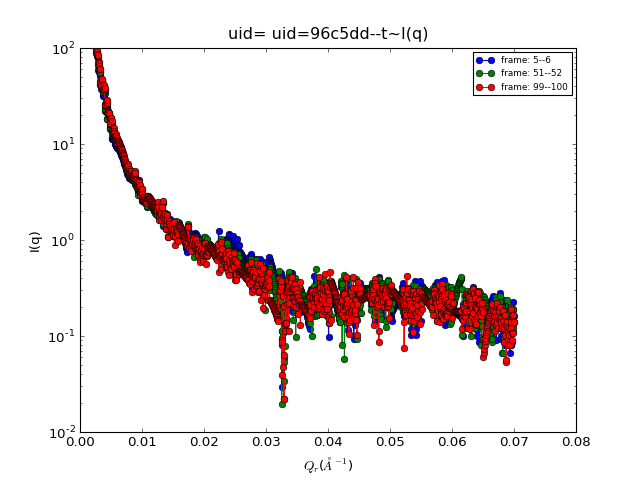

In [311]:
plot_t_qrc( qr_t, time_edge, pargs=setup_pargs, xlim = [0,0.08], ylim=[1e-2, 100.0])

## Do a waterfall analysis

In [233]:
if run_waterfall:    
    wat = cal_waterfallc( FD, roi_mask, qindex= qth_interest, save =True, path=data_dir, uid=uidstr)

Get waterfall for q index=3: 100%|██████████| 95/95 [00:00<00:00, 149.99it/s]


<IPython.core.display.Javascript object>


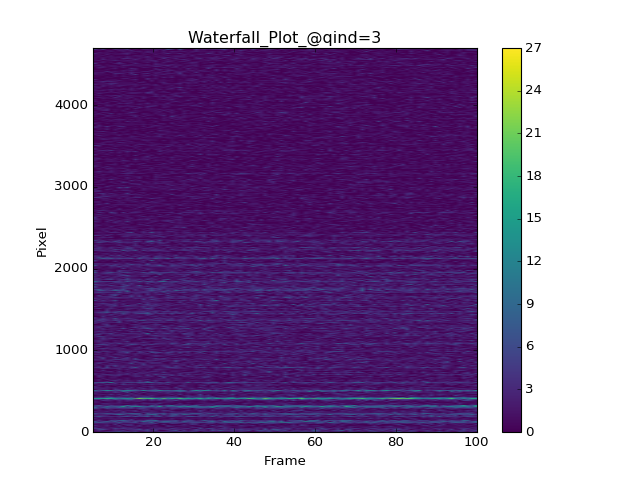

In [234]:
if run_waterfall: 
    plot_waterfallc( wat, qth_interest, aspect=None, 
                        vmax= np.max(wat), uid=uidstr, save =True, 
                        path=data_dir, beg= FD.beg)

Get ROI intensity of each frame: 100%|██████████| 95/95 [00:00<00:00, 163.57it/s]


<IPython.core.display.Javascript object>


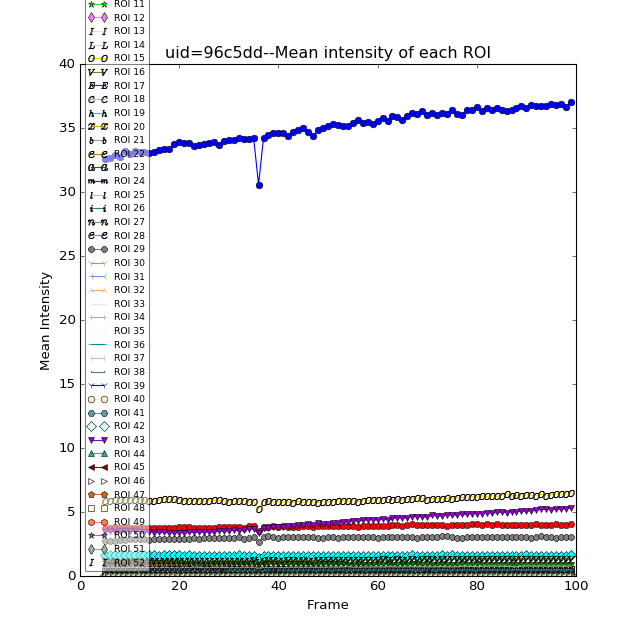

The file: uid=96c5dd_t_ROIs is saved in /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/


In [236]:
ring_avg = None    
if run_t_ROI_Inten:
    times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, roi_mask, timeperframe = None,  ) 
    plot_each_ring_mean_intensityc( times_roi, mean_int_sets,  uid = uidstr, save=True, path=data_dir )
    roi_avg = np.average( mean_int_sets, axis=0)
    

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [245]:
define_good_series = False
if define_good_series:
    FD = Multifile(filename, beg = good_start, end = Nimg)
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )

In [238]:
lag_steps = None
if use_sqnorm:
    norm = get_pixelist_interp_iq( qp_saxs, iq_saxs, roi_mask, center)
else:
    norm=None 
if use_imgsum_norm:
    imgsum_ = imgsum
else:
    imgsum_ = None     

In [239]:
if run_one_time: 
    t0 = time.time()    
    g2, lag_steps  = cal_g2p( FD,  roi_mask, bad_frame_list,good_start, num_buf = 8, num_lev= None,
                            imgsum= imgsum_, norm=norm )
    run_time(t0)
    

In this g2 calculation, the buf and lev number are: 8--5--
Bad frame involved and will be precessed!
95 frames will be processed...


  0%|          | 0/52 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/52 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 52/52 [00:01<00:00, 35.36it/s]

G2 calculation DONE!
Total time: 0.32 min


In [240]:
if run_one_time: 
    taus = lag_steps * timeperframe    
    g2_pds = save_g2_general( g2, taus=taus,qr=np.array( list( qval_dict.values() ) )[:,0],
                             uid=uid_+'_g2.csv', path= data_dir, return_res=True )

The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/ with filename as uid=96c5dd_fra_5_100_g2.csv


### Plot the one time correlation functions

In [241]:
#if run_one_time:
#    plot_g2_general( g2_dict={1:g2}, taus_dict={1:taus},vlim=[0.95, 1.05], qval_dict = qval_dict, fit_res= None, 
#                geometry=scat_geometry,filename=uid_+'_g2',path= data_dir,   ylabel='g2')

# Fit g2

In [242]:
if run_one_time:
    g2_fit_result, taus_fit, g2_fit = get_g2_fit_general( g2,  taus, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
    g2_fit_paras = save_g2_fit_para_tocsv(g2_fit_result,  filename= uid_  +'_g2_fit_paras.csv', path=data_dir ) 
    

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/uid=96c5dd_fra_5_100_g2_fit_paras.csv


<IPython.core.display.Javascript object>


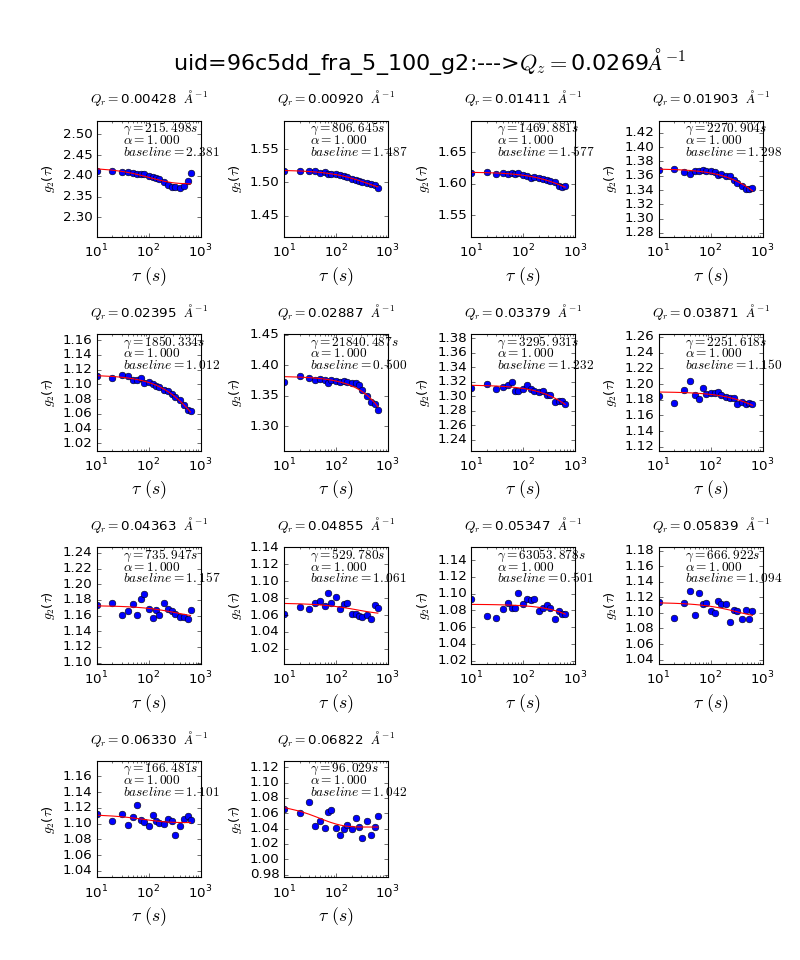

<IPython.core.display.Javascript object>


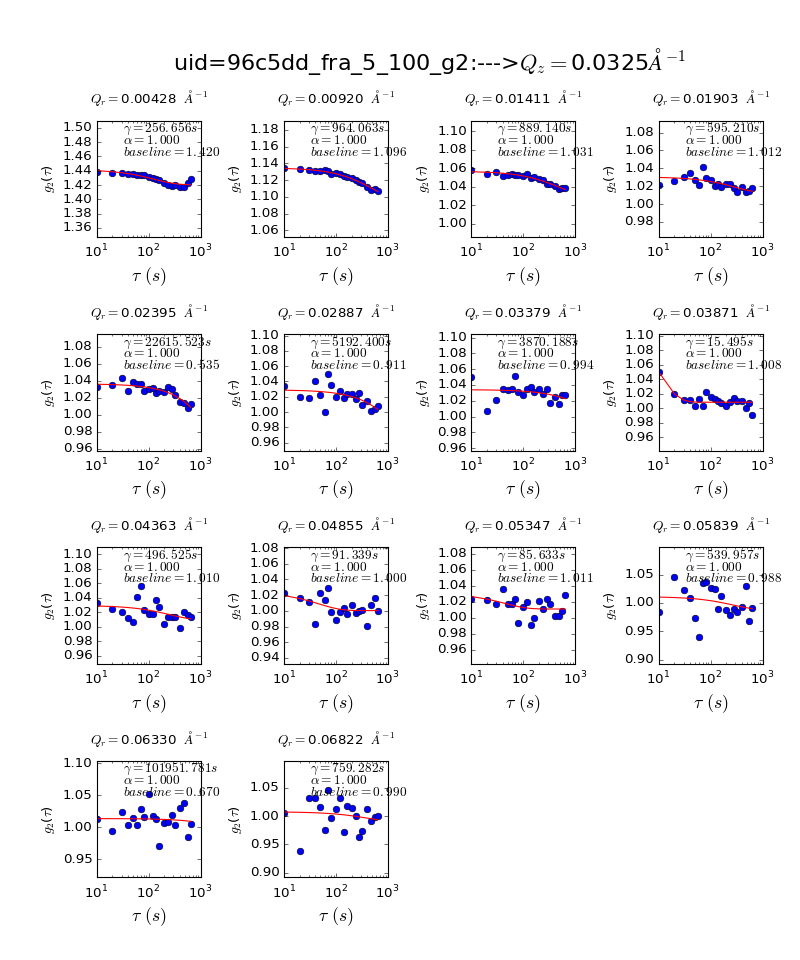

<IPython.core.display.Javascript object>


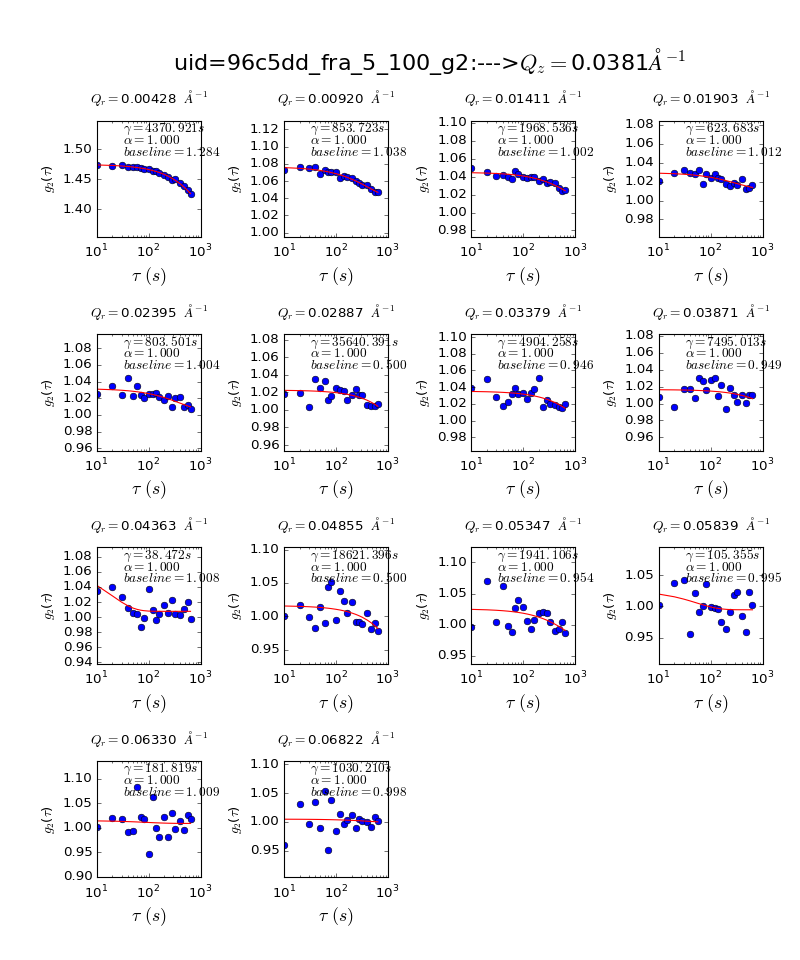

<IPython.core.display.Javascript object>


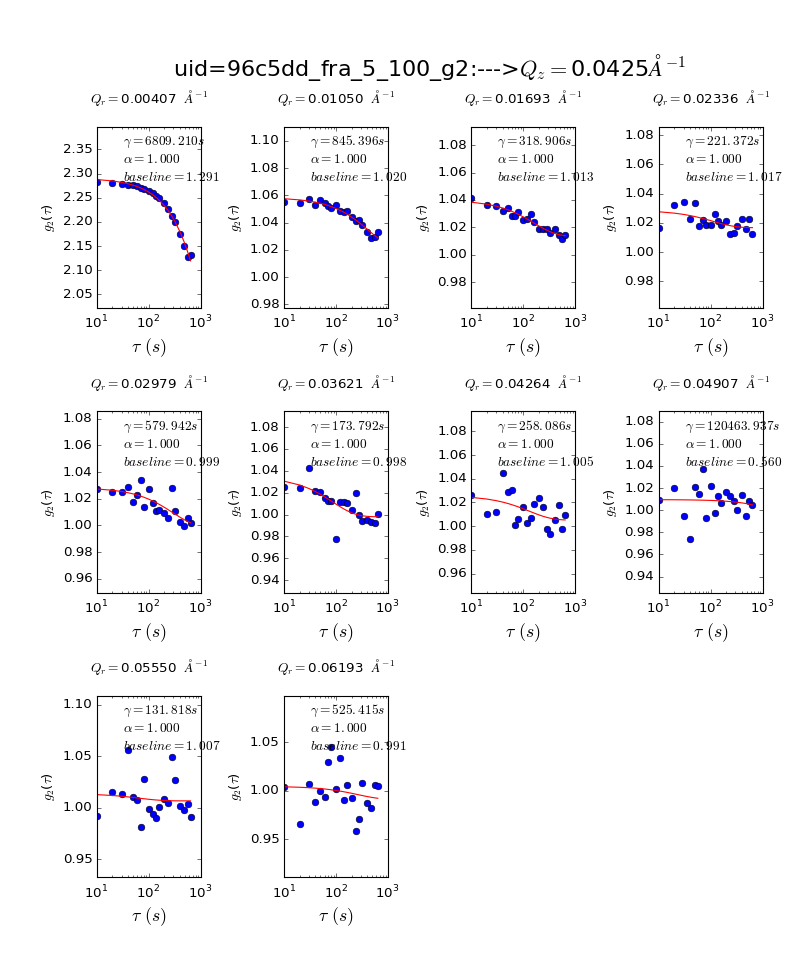

The combined image is saved as: /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/uid=96c5dd_fra_5_100_g2_fit.png


In [243]:
if run_one_time:
    plot_g2_general( g2_dict={1:g2, 2:g2_fit}, taus_dict={1:taus, 2:taus_fit},vlim=[0.95, 1.05],
                qval_dict = qval_dict, fit_res= g2_fit_result,  geometry=scat_geometry,filename= uid_+'_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_fit')

The fitted diffusion coefficient D0 is:  1.212e+00   A^2S-1
The fitted diffusion coefficient D0 is:  2.431e+00   A^2S-1
The fitted diffusion coefficient D0 is:  1.567e+00   A^2S-1
The fitted diffusion coefficient D0 is:  1.390e+00   A^2S-1


<IPython.core.display.Javascript object>


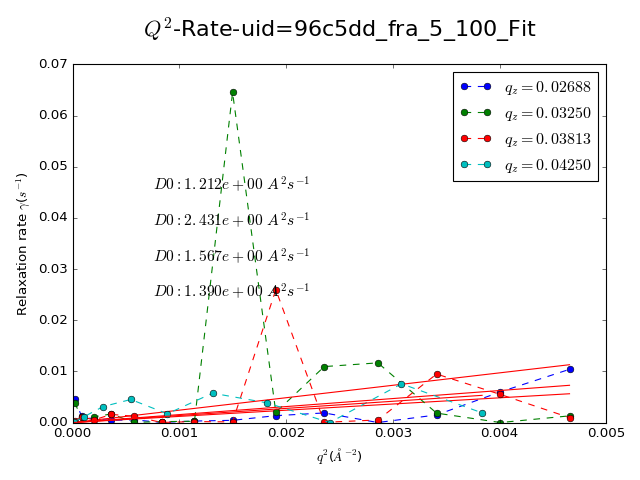

In [244]:
if run_one_time:
    D0, qrate_fit_res = get_q_rate_fit_general(  qval_dict, g2_fit_paras['relaxation_rate'], geometry= scat_geometry )
    plot_q_rate_fit_general( qval_dict, g2_fit_paras['relaxation_rate'],  qrate_fit_res, 
                            geometry= scat_geometry,uid=uid_  , path= data_dir )

# For two-time

In [246]:
data_pixel = None
if run_two_time:    
    data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm= norm ).get_data()

100%|██████████| 95/95 [00:01<00:00, 58.45it/s]


In [247]:
t0=time.time()
g12b=None
if run_two_time:     
    g12b = auto_two_Arrayc(  data_pixel,  roi_mask, index = None   )
run_time( t0 )        

100%|██████████| 52/52 [00:00<00:00, 93.50it/s]

Total time: 0.01 min


<IPython.core.display.Javascript object>


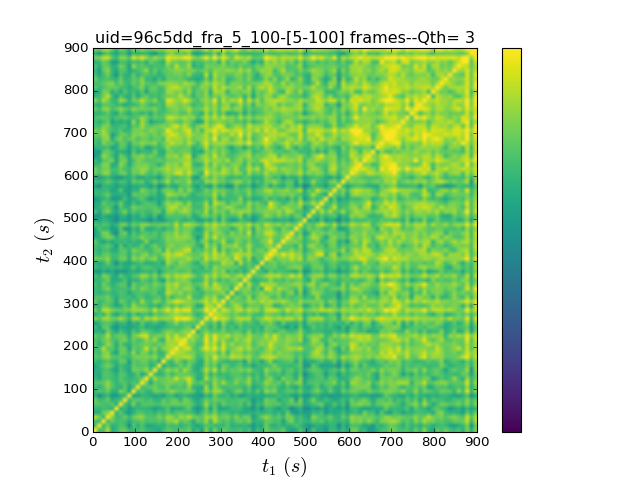

In [248]:
if run_two_time:
    show_C12(g12b, q_ind= qth_interest, N1= FD.beg, N2=min( FD.end,1000), vmin=1.1, vmax=1.45,
             timeperframe=timeperframe,save=True, path= data_dir, uid = uid_ )

In [256]:
if run_two_time:
    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
        
    #max_taus= lag_steps.max()  
    max_taus = Nimg    
    t0=time.time()
    g2b = get_one_time_from_two_time(g12b)[:max_taus]
    run_time(t0)
    tausb = np.arange( g2b.shape[0])[:max_taus] *timeperframe     
    g2b_pds = save_g2_general( g2b, taus=tausb, qr= np.array( list( qval_dict.values() ) )[:,0],
                              qz=None, uid=uid_ +'_g2b.csv', path= data_dir, return_res=True )
    

Total time: 0.00 min
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/ with filename as uid=96c5dd_fra_5_100_g2b.csv


In [257]:
if run_two_time:
    g2_fit_resultb, taus_fitb, g2_fitb = get_g2_fit_general( g2b,  tausb, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
                fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
                guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
    
    g2b_fit_paras = save_g2_fit_para_tocsv(g2_fit_resultb, 
                    filename= '%s'%uid_  + '_g2b_fit_paras.csv', path=data_dir )

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/uid=96c5dd_fra_5_100_g2b_fit_paras.csv


<IPython.core.display.Javascript object>


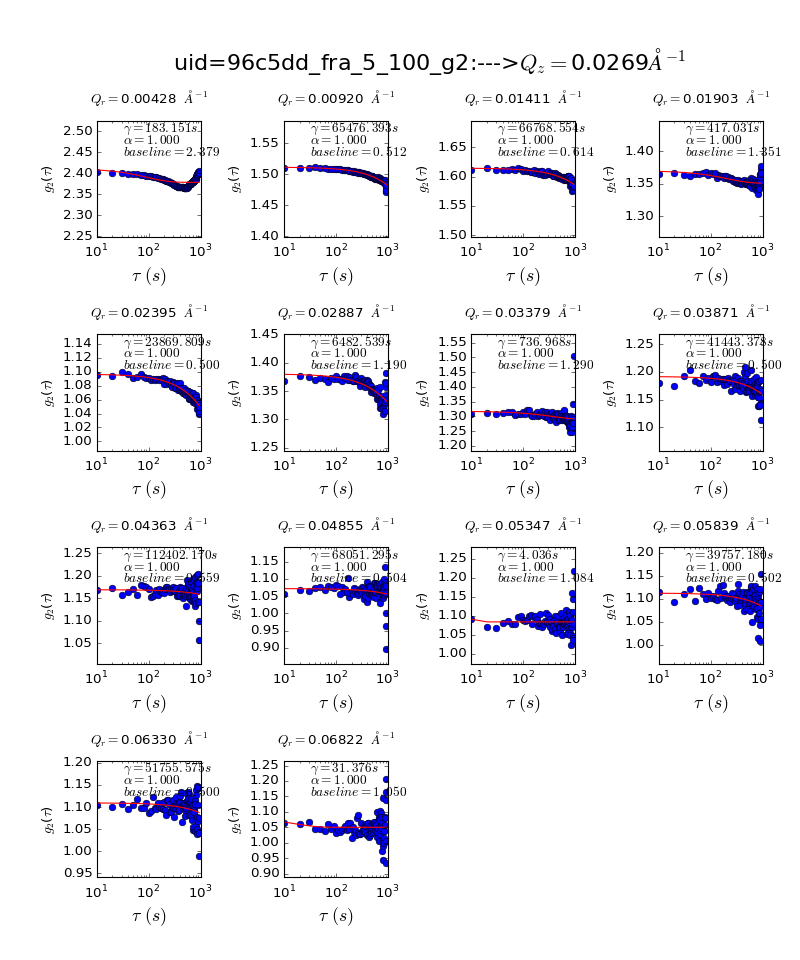

<IPython.core.display.Javascript object>


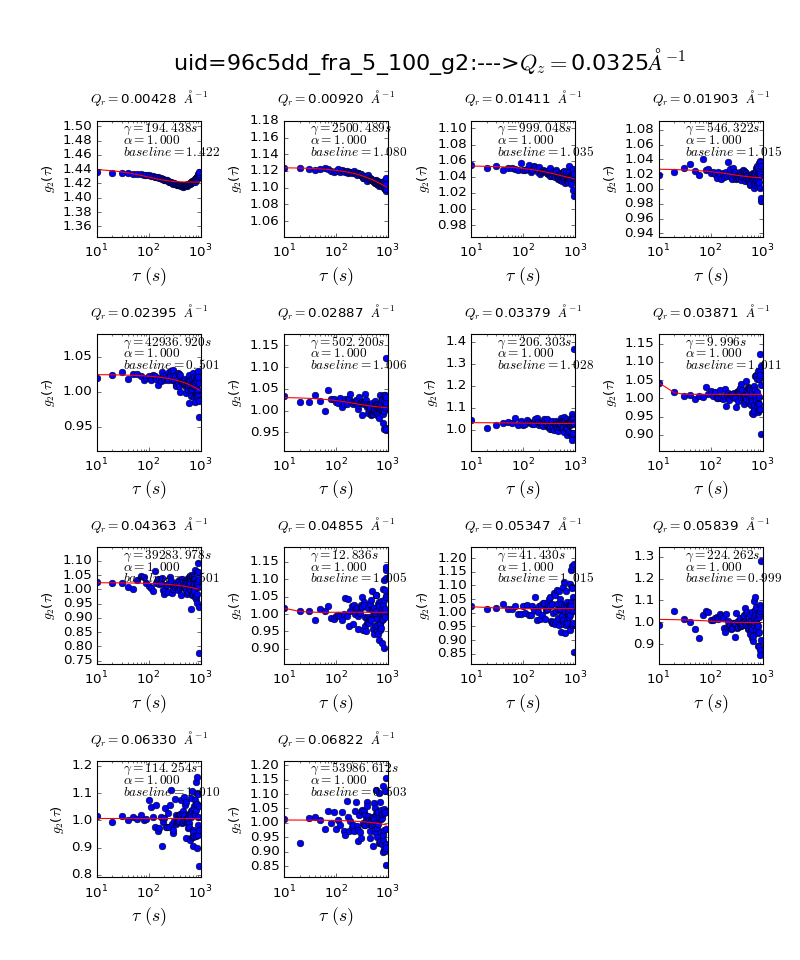

<IPython.core.display.Javascript object>


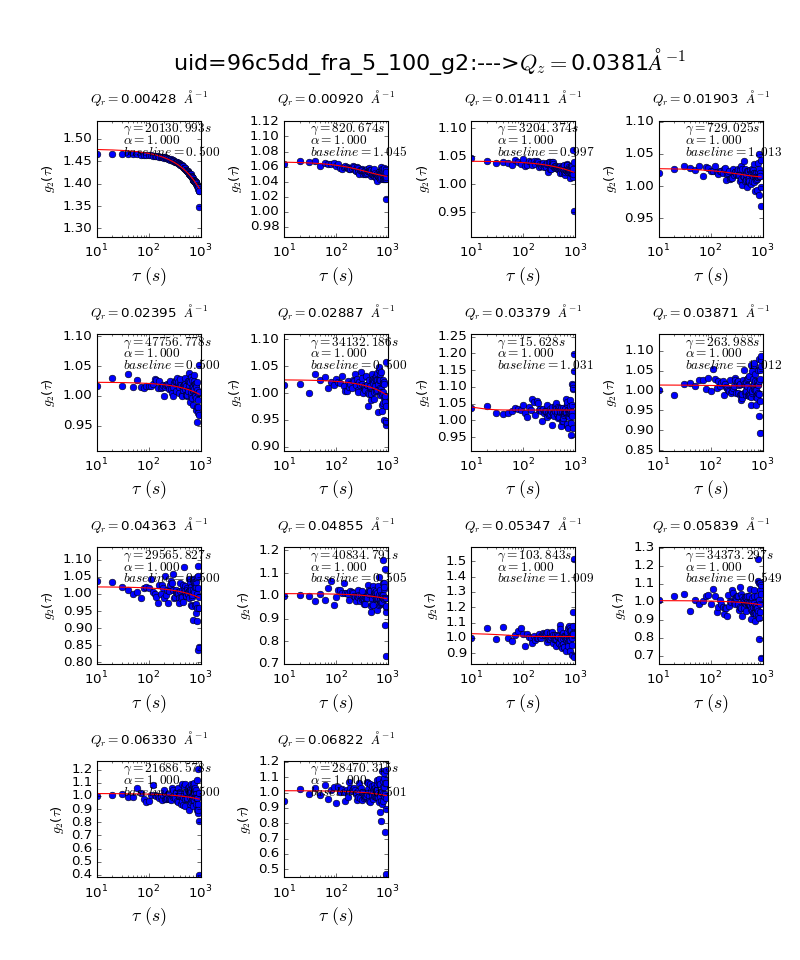

<IPython.core.display.Javascript object>


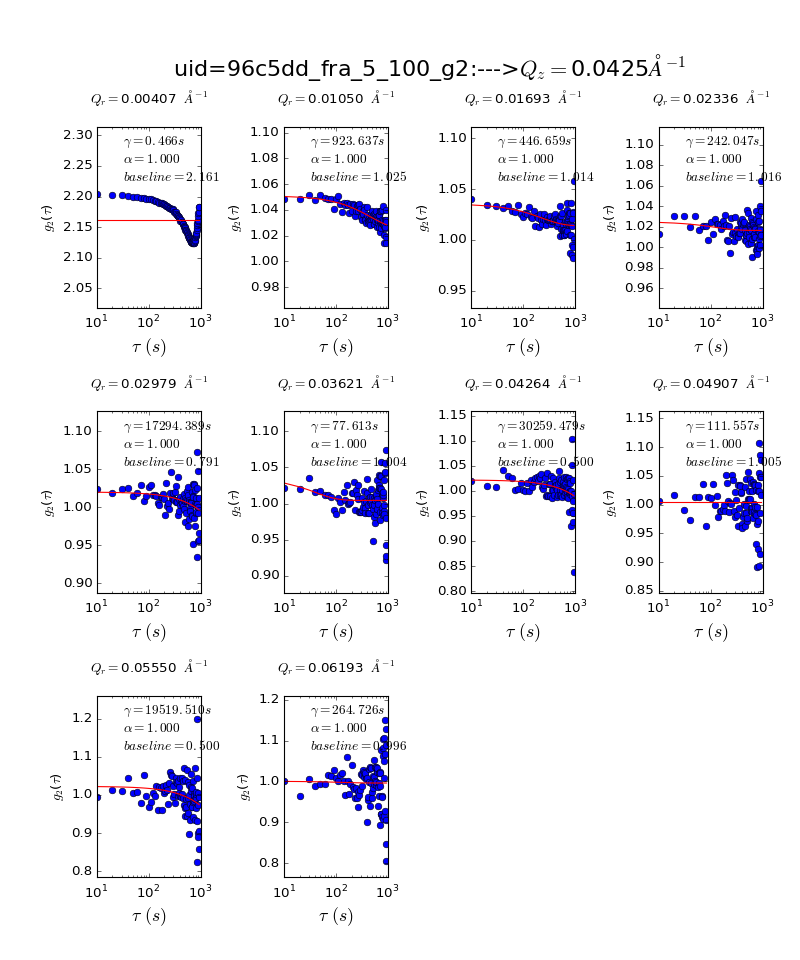

The combined image is saved as: /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/uid=96c5dd_fra_5_100_g2_b_fit.png


In [258]:
if run_two_time:
    plot_g2_general( g2_dict={1:g2b, 2:g2_fitb}, taus_dict={1:tausb, 2:taus_fitb},vlim=[0.95, 1.05],
                qval_dict=qval_dict, fit_res= g2_fit_resultb,  geometry=scat_geometry,filename=uid_+'_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_b_fit')

<IPython.core.display.Javascript object>


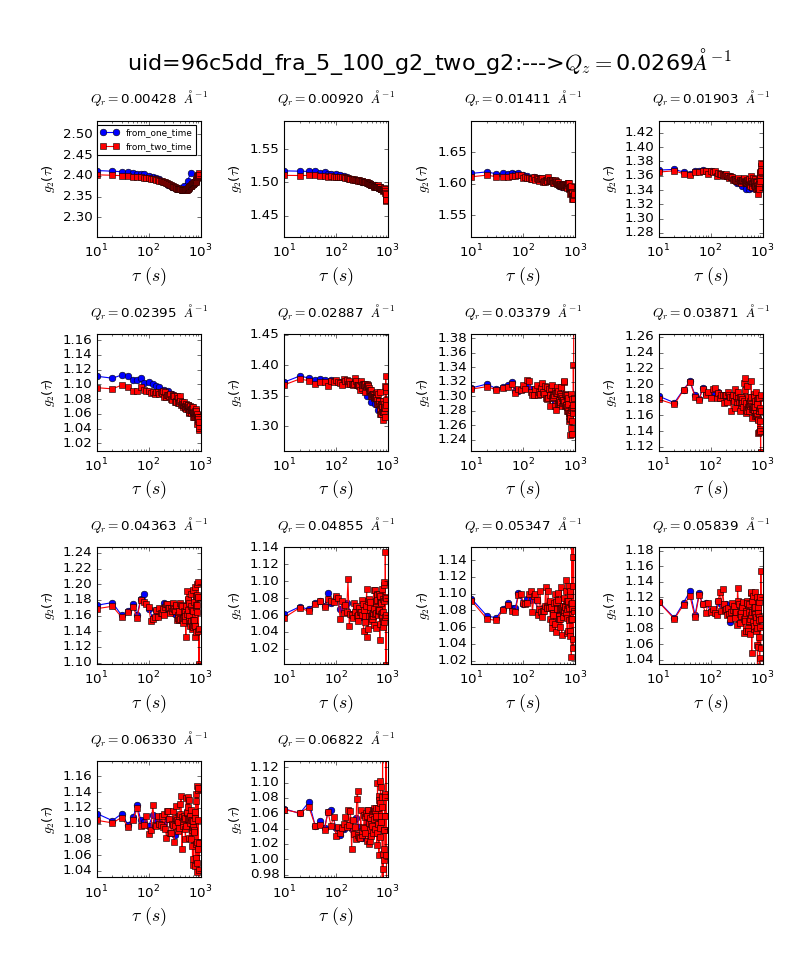

<IPython.core.display.Javascript object>


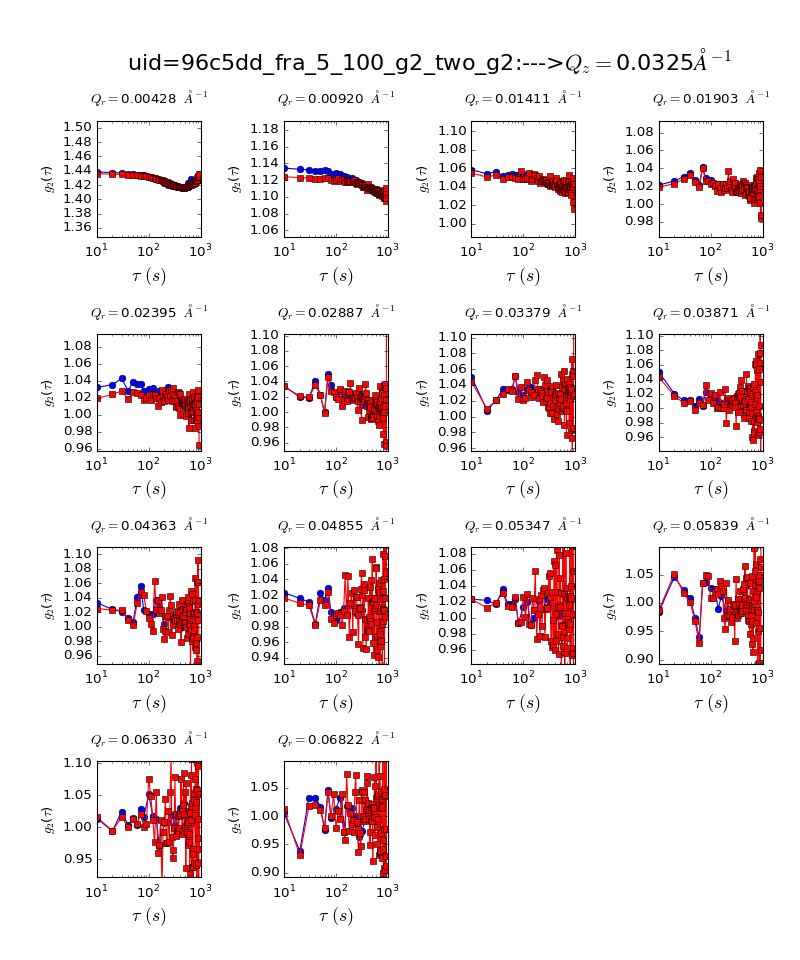

<IPython.core.display.Javascript object>


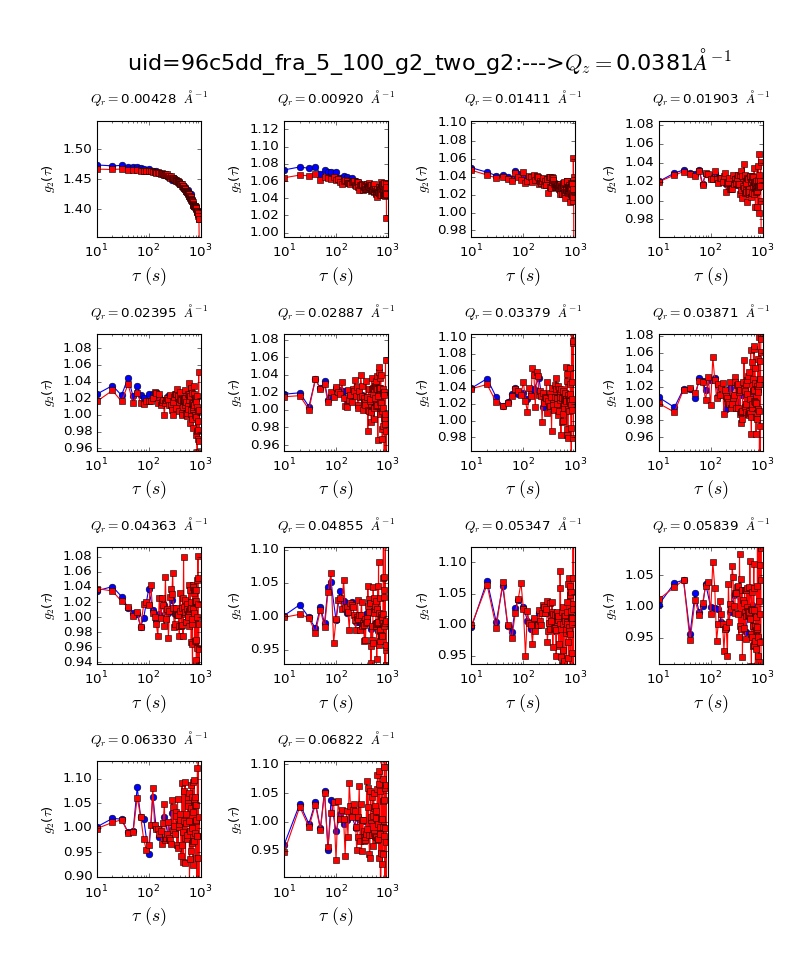

<IPython.core.display.Javascript object>


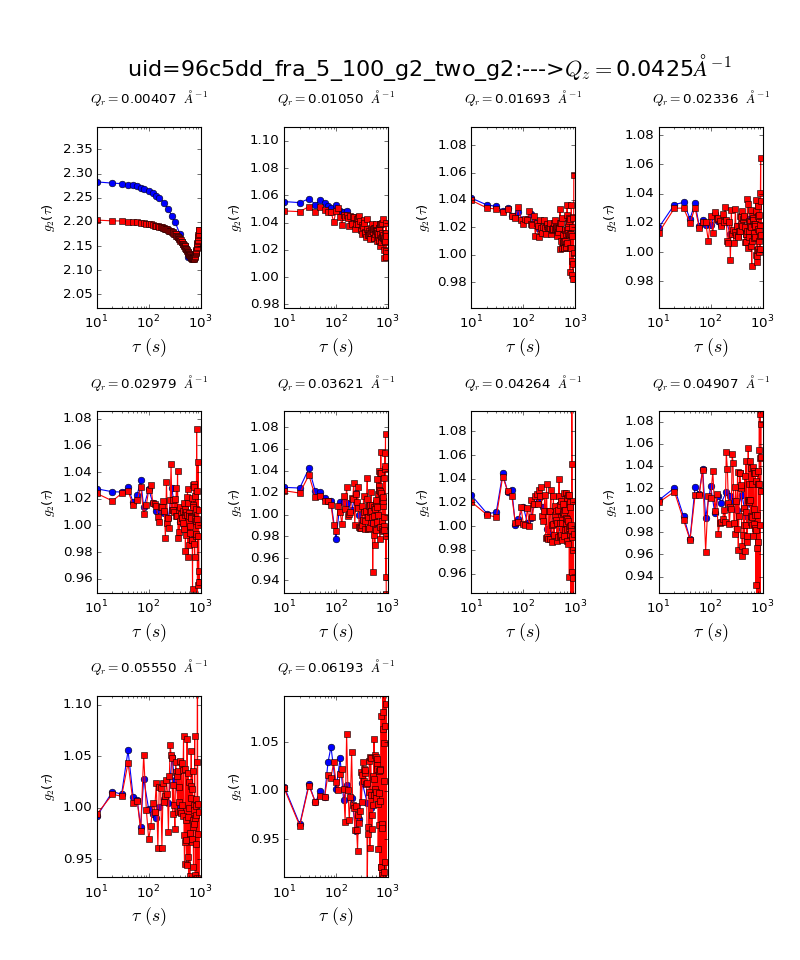

The combined image is saved as: /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/uid=96c5dd_fra_5_100_g2_two_g2.png


In [259]:
if run_two_time and run_one_time:
    plot_g2_general( g2_dict={1:g2, 2:g2b}, taus_dict={1:taus, 2:tausb},vlim=[0.95, 1.05],
                qval_dict=qval_dict, g2_labels=['from_one_time', 'from_two_time'],
            geometry=scat_geometry,filename=uid_+'_g2_two_g2', path= data_dir, ylabel='g2', )

# Four Time Correlation

In [260]:
if run_four_time:
    t0=time.time()
    g4 = get_four_time_from_two_time(g12b, g2=g2b)[:max_taus]
    run_time(t0)

Total time: 0.00 min


In [261]:
if run_four_time:
    taus4 = np.arange( g4.shape[0])*timeperframe        
    g4_pds = save_g2_general( g4, taus=taus4, qr=np.array( list( qval_dict.values() ) )[:,0],
                             qz=None, uid=uid_ +'_g4.csv', path= data_dir, return_res=True )
     


The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/ with filename as uid=96c5dd_fra_5_100_g4.csv


<IPython.core.display.Javascript object>


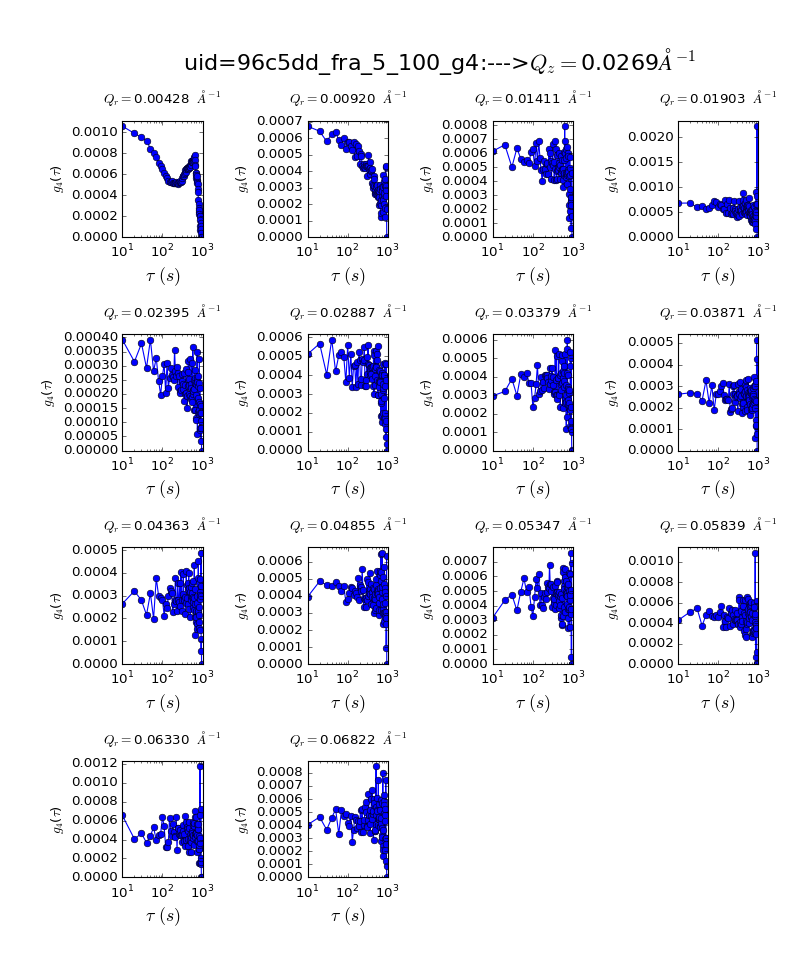

<IPython.core.display.Javascript object>


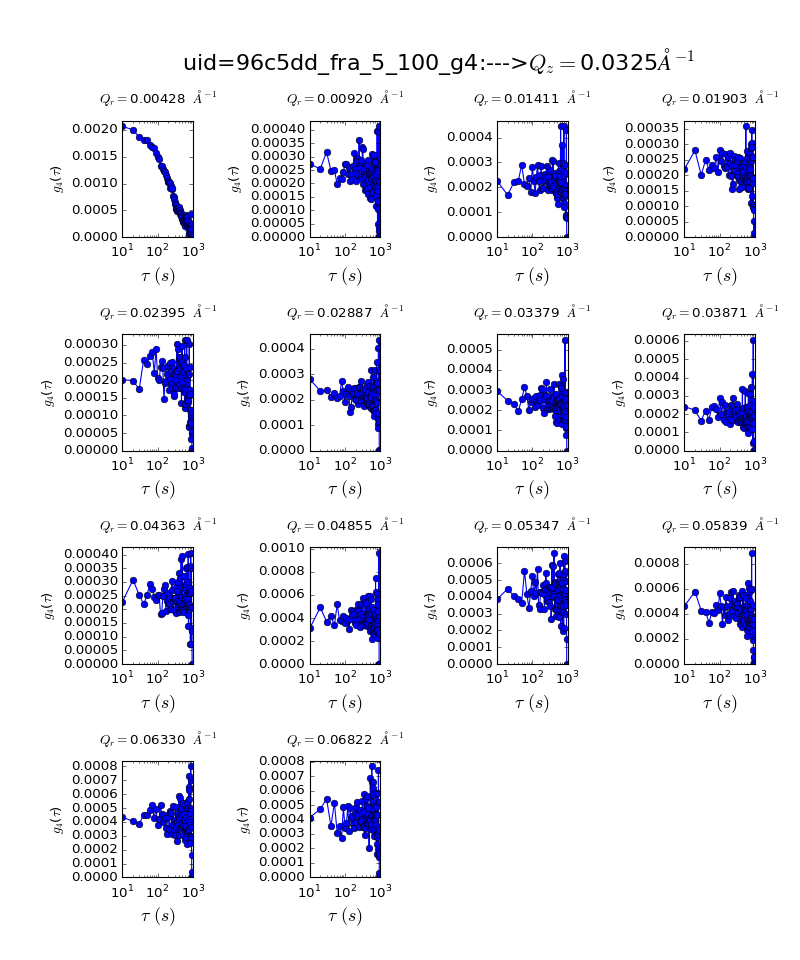

<IPython.core.display.Javascript object>


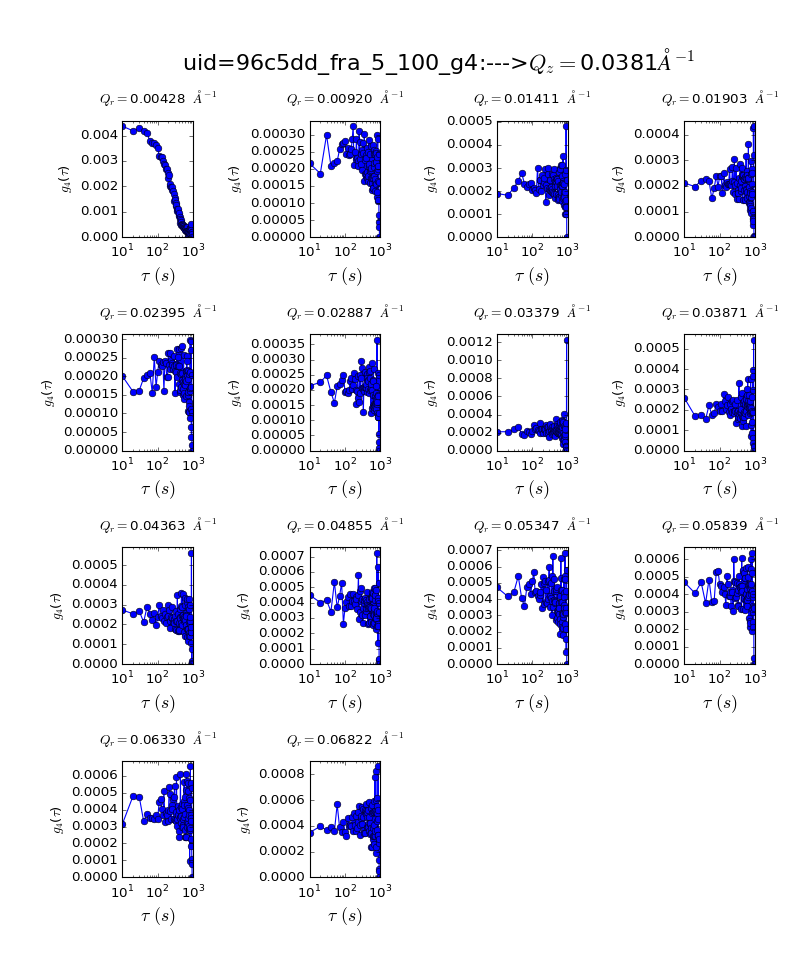

<IPython.core.display.Javascript object>


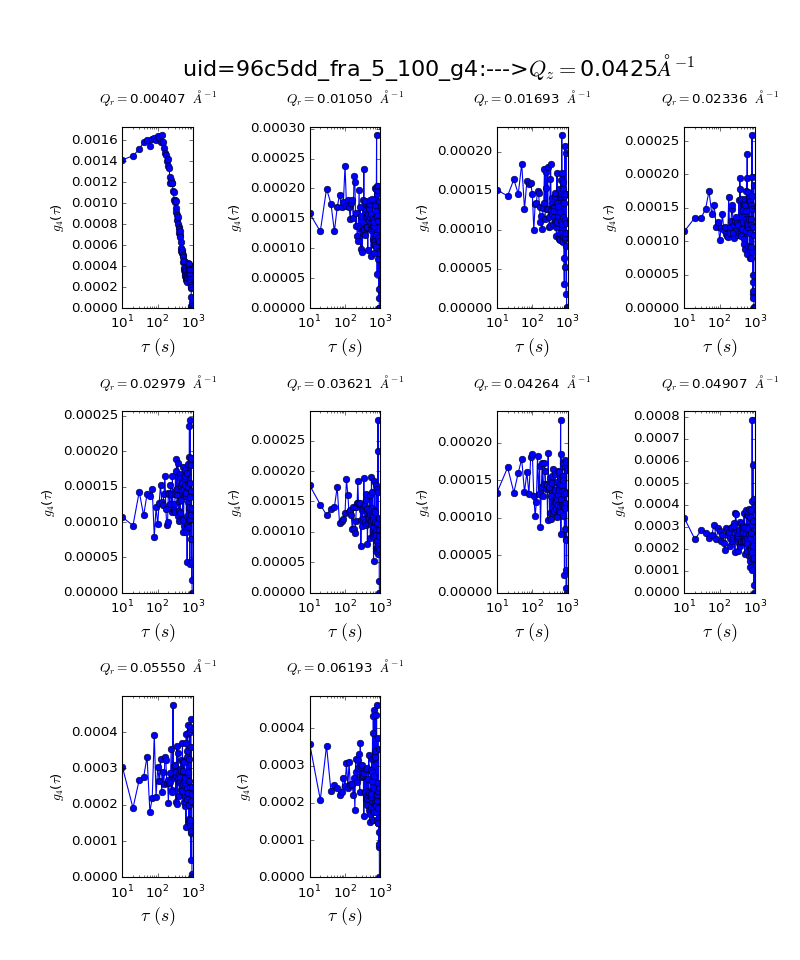

The combined image is saved as: /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/uid=96c5dd_fra_5_100_g4.png


In [262]:
if run_four_time:
    plot_g2_general( g2_dict={1:g4}, taus_dict={1:taus4},vlim=[0.95, 1.05], qval_dict=qval_dict, fit_res= None, 
                geometry=scat_geometry,filename=uid_+'_g4',path= data_dir,   ylabel='g4')

# Speckel Visiblity

In [263]:
if run_xsvs:    
    max_cts = get_max_countc(FD, roi_mask )
    qind, pixelist = roi.extract_label_indices(   roi_mask  )
    noqs = len( np.unique(qind) )
    nopr = np.bincount(qind, minlength=(noqs+1))[1:]
    #time_steps = np.array( utils.geometric_series(2,   len(imgs)   ) )
    time_steps = [0,1]  #only run the first two levels
    num_times = len(time_steps)    
    times_xsvs = exposuretime + (2**(  np.arange( len(time_steps) ) ) -1 ) * acquisition_period    
    print( 'The max counts are: %s'%max_cts )


### Do historam 

In [264]:
if run_xsvs:
    if roi_avg is  None:
        times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, roi_mask, timeperframe = None,  ) 
        roi_avg = np.average( mean_int_sets, axis=0)
    
    t0=time.time()
    spec_bins, spec_his, spec_std  =  xsvsp( FD, np.int_(roi_mask), norm=None,
                max_cts=int(max_cts+2),  bad_images=bad_frame_list, only_two_levels=True )    
    spec_kmean =  np.array(  [roi_avg * 2**j for j in  range( spec_his.shape[0] )] )
    run_time(t0)
    spec_pds =  save_bin_his_std( spec_bins, spec_his, spec_std, filename=uid_+'_spec_res.csv', path=data_dir ) 

### Do historam fit by negtive binominal function with maximum likehood method

In [275]:
if run_xsvs:    
    ML_val, KL_val,K_ = get_xsvs_fit(  spec_his, spec_kmean,  spec_std, max_bins=2,varyK= False, )
    #print( 'The observed average photon counts are: %s'%np.round(K_mean,4))
    #print( 'The fitted average photon counts are: %s'%np.round(K_,4)) 
    print( 'The difference sum of average photon counts between fit and data are: %s'%np.round( 
            abs(np.sum( spec_kmean[0,:] - K_ )),4))
    print( '#'*30)
    qth=   10 
    print( 'The fitted M for Qth= %s are: %s'%(qth, ML_val[qth]) )
    print( K_[qth])
    print( '#'*30)

## Plot fit results

In [276]:
if run_xsvs:   
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std=spec_std,
                  xlim = [0,10], vlim =[.9, 1.1],
        uid=uid_, qth= qth_interest, logy= True, times= times_xsvs, q_ring_center=qr, path=data_dir)
    
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std = spec_std,
                  xlim = [0,15], vlim =[.9, 1.1],
        uid=uid_, qth= None, logy= True, times= times_xsvs, q_ring_center=qr, path=data_dir )

### Get contrast

In [277]:
if run_xsvs:
    contrast_factorL = get_contrast( ML_val)
    spec_km_pds = save_KM(  spec_kmean, KL_val, ML_val, qs=qr, level_time=times_xsvs, uid=uid_, path = data_dir )
    #spec_km_pds

### Plot contrast with g2 restuls

In [278]:
if run_xsvs:    
    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, qr, 
                     vlim=[0.8,1.2], qth = qth_interest, uid=uid_,path = data_dir, legend_size=14)

    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, qr, 
                     vlim=[0.8,1.2], qth = None, uid=uid_,path = data_dir, legend_size=4)

# Export Results to a HDF5 File

In [292]:
md['mask_file']= mask_path + mask_name
md['mask'] = mask
md['NOTEBOOK_FULL_PATH'] = None
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list
md['avg_img'] = avg_img
md['roi_mask'] = roi_mask

if scat_geometry == 'gi_saxs':        
    md['Qr'] = Qr
    md['Qz'] = Qz
    md['qval_dict'] = qval_dict
    md['beam_center_x'] =  inc_x0
    md['beam_center_y']=   inc_y0
    md['beam_refl_center_x'] = refl_x0
    md['beam_refl_center_y'] = refl_y0

else:
    md['qr']= qr
    md['qr_edge'] = qr_edge
    md['qval_dict'] = qval_dict
    md['beam_center_x'] =  center[1]
    md['beam_center_y']=  center[0]            

md['beg'] = FD.beg
md['end'] = FD.end
md['metadata_file'] = data_dir + 'md.csv-&-md.pkl'
psave_obj(  md, data_dir + 'uid=%s_md'%uid ) #save the setup parameters
save_dict_csv( md,  data_dir + 'uid=%s_md.csv'%uid, 'w')

Exdt = {} 
if scat_geometry == 'gi_saxs':  
    for k,v in zip( ['md', 'roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list', 'qr_1d_pds'], 
                [md,    roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list, qr_1d_pds] ):
        Exdt[ k ] = v
elif scat_geometry == 'saxs': 
    for k,v in zip( ['md', 'q_saxs', 'iq_saxs','iqst','qt','roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list'], 
                [md, q_saxs, iq_saxs, iqst, qt,roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list] ):
        Exdt[ k ] = v

if run_waterfall:Exdt['wat'] =  wat
if run_t_ROI_Inten:Exdt['times_roi'] = times_roi;Exdt['mean_int_sets']=mean_int_sets
if run_one_time:
    for k,v in zip( ['taus','g2','g2_fit_paras'], [taus,g2,g2_fit_paras] ):Exdt[ k ] = v
if run_two_time:
    for k,v in zip( ['tausb','g2b','g2b_fit_paras', 'g12b'], [tausb,g2b,g2b_fit_paras,g12b] ):Exdt[ k ] = v
if run_four_time:
    for k,v in zip( ['taus4','g4'], [taus4,g4] ):Exdt[ k ] = v
if run_xsvs:
    for k,v in zip( ['spec_kmean','spec_pds','times_xsvs','spec_km_pds','contrast_factorL'], 
                   [ spec_kmean,spec_pds,times_xsvs,spec_km_pds,contrast_factorL] ):Exdt[ k ] = v 

In [295]:
export_xpcs_results_to_h5( 'uid=%s_Res.h5'%md['uid'], data_dir, export_dict = Exdt )
#extract_dict = extract_xpcs_results_from_h5( filename = 'uid=%s_Res.h5'%md['uid'], import_dir = data_dir )

The xpcs analysis results are exported to /XF11ID/analysis/2016_3/yuzhang/Results/96c5dd/ with filename as uid=96c5dddd-fe04-4385-9ef6-93669e408486_Res.h5


# Creat PDF Report

In [271]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
pdf_filename = "XPCS_Analysis_Report_for_uid=%s%s.pdf"%(uid,pdf_version)
if run_xsvs:
    pdf_filename = "XPCS_XSVS_Analysis_Report_for_uid=%s%s.pdf"%(uid,pdf_version)

In [272]:
make_pdf_report( data_dir, uid, pdf_out_dir, pdf_filename, username, 
                    run_fit_form,run_one_time, run_two_time, run_four_time, run_xsvs, report_type= scat_geometry
                   )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_Analysis_Report_for_uid=96c5dd_1.pdf
****************************************


In [273]:
#att_pdf_report = True

## Attach the PDF report to Olog 

In [274]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    pname = pdf_out_dir + pdf_filename 
    atch=[  Attachment(open(pname, 'rb')) ] 
    try:
        update_olog_uid( uid= md['uid'], text='Add XPCS Analysis PDF Report', attachments= atch )
    except:
        print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%pname)

I can't attach this PDF: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_Analysis_Report_for_uid=96c5dd_1.pdf due to a duplicated filename. Please give a different PDF file.


# The End!